In [1]:
#Load required modules
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import math
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from scipy.signal import argrelextrema
import multiprocessing
import emcee
import corner

In [2]:
#Define cosmology
cosmo = FlatLambdaCDM(H0=71, Om0=0.2648)

#Load WCS
with fits.open('image_header.fits') as hdul: 
    image_WCS = WCS(hdul[0].header)
    hdul.close()

print(image_WCS)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 227.72813328923 5.713460044834 
CRPIX : 24000.0 24000.0 
PC1_1 PC1_2  : -7.305555555548e-05 0.0 
PC2_1 PC2_2  : 0.0 7.3055555555479e-05 
CDELT : 1.0 1.0 
NAXIS : 0  0


In [3]:
#Define cluster properties
class Cluster:
    def __init__(self, name, ra, dec, redshift):
        self.name = name
        self.ra = ra
        self.dec = dec
        self.redshift = redshift
        self.x = image_WCS.wcs_world2pix(ra, dec, 1)[0]
        self.y = image_WCS.wcs_world2pix(ra, dec, 1)[1]
        self.SC = SkyCoord(self.ra, self.dec, unit=(u.deg, u.deg), frame='icrs') #Unit: Degrees
        
#Define clusters manually; Cluster1 is the origin of the system around which the filaments will be detected
Cluster1 = Cluster('A2029', 227.73, 5.72, 0.0766) #A2029
Cluster2 = Cluster('A2033', 227.85, 6.32, 0.0817) #A2033
Cluster3 = Cluster('SIS', 227.77, 5.304444, 0.0802) #SIS

#Distance and angle between A2029 and A20233
#We use the distance between A2029 and A2033 or 'intercluster_distance' as a reference distance and set the radial cutoffs 'r1' and 'r2' as ratios of this distance
intercluster_distance = math.dist([Cluster1.x, Cluster1.y], [Cluster2.x, Cluster2.y])
intercluster_separation = Cluster1.SC.separation(Cluster2.SC)
intercluster_position_angle = Cluster1.SC.position_angle(Cluster2.SC) #Measured from the N due W 
intercluster_angle = intercluster_position_angle.rad + math.pi/2 #In radians

#Separation and angle between A2029 and SIG
intercluster_separation_2 = Cluster1.SC.separation(Cluster3.SC)
intercluster_position_angle_2 = Cluster1.SC.position_angle(Cluster3.SC) #Measured from the N due W 
intercluster_angle_2 = intercluster_position_angle_2.rad + math.pi/2 #In radians

In [4]:
#Load shear catalog
df = pd.read_csv('shear_catalog.csv')
df

,ra,dec,g1,g2
0,228.330154,5.243735,0.007678,-0.422590
1,228.329819,5.251708,0.022146,0.011462
2,228.333091,5.254002,-0.032060,-0.034183
3,228.315356,5.255023,-0.011428,0.413245
4,228.319373,5.264059,0.415128,-0.573637
...,...,...,...,...
83664,227.135133,6.173448,0.150012,-0.371007
83665,227.125704,6.182342,0.253262,-0.390751
83666,227.123391,6.186939,0.050436,-0.189138
83667,227.136469,6.202266,0.087353,-0.183286


In [5]:
#Define cell size
cell_size = 15 #Use a cell size small enough such that 'Avg Galaxies per non-empty Bin' is close to 1 

#Add x and y columns to dataframe
df['x'] = (image_WCS.wcs_world2pix(df['ra'], df['dec'], 1))[0]
df['y'] = (image_WCS.wcs_world2pix(df['ra'], df['dec'], 1))[1]

#Get binned shear components
#Define grid limits  
grid_x_min = math.floor(min(df['x']))
grid_x_max = math.ceil(max(df['x']))
grid_y_min = math.floor(min(df['y']))
grid_y_max = math.ceil(max(df['y']))

#Create grid that covers all points (Choice 1) 
x_edges = np.arange(grid_x_min, grid_x_max + cell_size, cell_size)
y_edges = np.arange(grid_y_min, grid_y_max + cell_size, cell_size)

# #Create grid (Choice 2) #If you want to avoid the grid starting at ~grid_x_min and be right-shifted. These choices have no real impact on the results
# x_edges = np.arange(grid_x_min-(cell_size/2), grid_x_max+(cell_size/2), cell_size)
# y_edges = np.arange(grid_y_min-(cell_size/2), grid_y_max+(cell_size/2), cell_size)

#Calculate grid shape 
grid_size = len(x_edges)-1, len(y_edges)-1
print('Grid Shape = ', grid_size) 

#Calculate grid length in radians (used later)
Ex1 = SkyCoord(image_WCS.wcs_pix2world(grid_x_min, (grid_y_min + grid_y_max)/2, 1)[0], image_WCS.wcs_pix2world(grid_x_min, (grid_y_min + grid_y_max)/2, 1)[1], unit=(u.deg, u.deg), frame='icrs') #Unit: Degrees
Ex2 = SkyCoord(image_WCS.wcs_pix2world(grid_x_max, (grid_y_min + grid_y_max)/2, 1)[0], image_WCS.wcs_pix2world(grid_x_max, (grid_y_min + grid_y_max)/2, 1)[1], unit=(u.deg, u.deg), frame='icrs') #Unit: Degrees
Ey1 = SkyCoord(image_WCS.wcs_pix2world((grid_x_min + grid_x_max)/2, grid_y_min, 1)[0], image_WCS.wcs_pix2world((grid_x_min + grid_x_max)/2, grid_y_min, 1)[1], unit=(u.deg, u.deg), frame='icrs') #Unit: Degrees
Ey2 = SkyCoord(image_WCS.wcs_pix2world((grid_x_min + grid_x_max)/2, grid_y_max, 1)[0], image_WCS.wcs_pix2world((grid_x_min + grid_x_max)/2, grid_y_max, 1)[1], unit=(u.deg, u.deg), frame='icrs') #Unit: Degrees

grid_angular_length_x = Ex1.separation(Ex2).value
grid_angular_length_y = Ey1.separation(Ey2).value

print('Angular Length X [degrees] = ', grid_angular_length_x)
print('Angular Length Y [degrees] = ', grid_angular_length_y)

#Assign galaxies to grid cells
df['x_bin'] = np.digitize(df['x'], x_edges)-1
df['y_bin'] = np.digitize(df['y'], y_edges)-1

#Create meshgrid for bin centers
grid_xc, grid_yc = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2, indexing = 'ij')

#Initialize arrays for grid values
grid_g1 = np.zeros_like(grid_xc)
grid_g2 = np.zeros_like(grid_xc)
grid_g_mag = np.zeros_like(grid_xc)
grid_g_phi = np.zeros_like(grid_xc)
density = np.zeros_like(grid_xc)

#Group the dataframe by x_bin and y_bin
grouped = df.groupby(['x_bin', 'y_bin'])

#Compute the necessary quantities
for (i, j), group in grouped:
    
    #Average reduced shear g1, g2
    grid_g1[i, j] = group['g1'].mean()
    grid_g2[i, j] = group['g2'].mean()
    
    #Magnitudes and angles
    grid_g_mag[i,j] = np.sqrt(grid_g1[i,j]**2 + grid_g2[i,j]**2)
    grid_g_phi[i,j] = 0.5 * np.arctan2(grid_g2[i,j], grid_g1[i,j])

    #Populate density matrix 
    density[i,j] = len(group)

#Get boolean matrix for occupied cells
occupied = density>0

num_galaxies_total = np.sum(density)
avg_density = num_galaxies_total/(density.size)
avg_density_in_non_empty_bins =  num_galaxies_total/np.sum(occupied)

print('Total number of galaxies =', np.sum(density))
print('Avg Galaxies per Bin =', avg_density)
print('Avg Galaxies per non-empty Bin =', avg_density_in_non_empty_bins)

Grid Shape =  (1396, 1392)
Angular Length X [degrees] =  1.5288159369859815
Angular Length Y [degrees] =  1.5250177087806065
Total number of galaxies = 83669.0
Avg Galaxies per Bin = 0.043056619075848894
Avg Galaxies per non-empty Bin = 1.0164119633615978


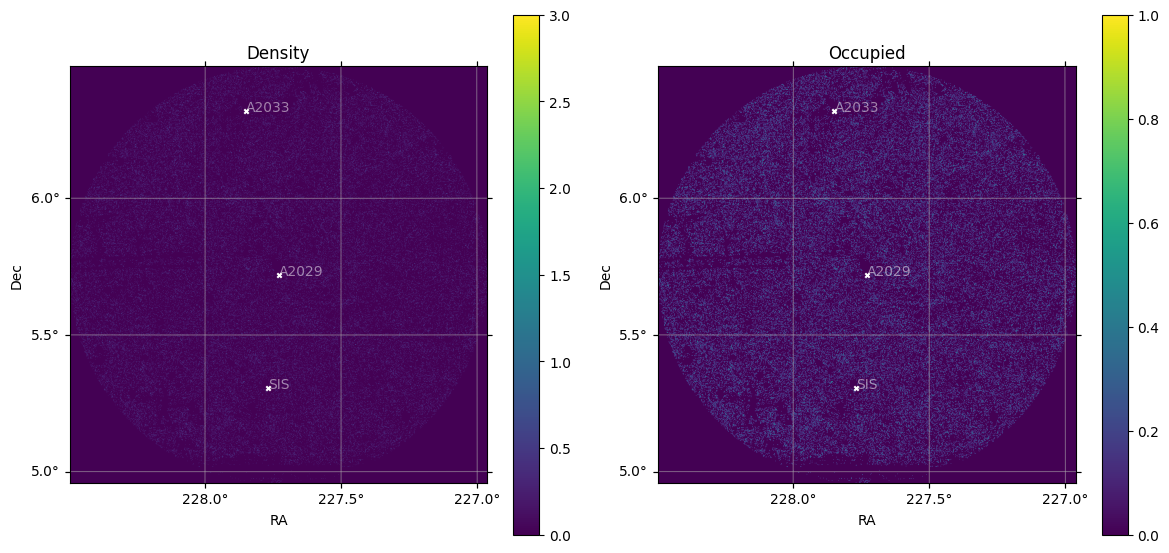

In [6]:
#Visualizing density 
fig = plt.figure(figsize=(12, 6))

#--- Density ---
ax1 = fig.add_subplot(1, 2, 1, projection=image_WCS)  
im1 = ax1.imshow(density.T, origin='lower', extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max])
fig.colorbar(im1, ax=ax1)
ax1.scatter(Cluster1.x, Cluster1.y, s=10, c='w', marker='x')
ax1.text(Cluster1.x + cell_size, Cluster1.y + cell_size, c = 'w', s=Cluster1.name, fontsize=10, alpha = 0.5)
ax1.scatter(Cluster2.x, Cluster2.y, s=10, c='w', marker='x')
ax1.text(Cluster2.x + cell_size, Cluster2.y + cell_size, c = 'w', s=Cluster2.name, fontsize=10, alpha = 0.5)
ax1.scatter(Cluster3.x, Cluster3.y, s=10, c='w', marker='x')
ax1.text(Cluster3.x + cell_size, Cluster3.y + cell_size, c = 'w', s=Cluster3.name, fontsize=10, alpha = 0.5)
ra = ax1.coords[0]
ra.set_axislabel('RA')
ra.set_major_formatter('d.d') 
dec = ax1.coords[1]
dec.set_axislabel('Dec')
dec.set_major_formatter('d.d')   
ax1.set_title('Density')
ax1.grid(True, alpha=0.5)

#--- Occupied bins ---
ax2 = fig.add_subplot(1, 2, 2, projection=image_WCS) 
im2 = ax2.imshow((occupied).T, origin='lower', extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max])
fig.colorbar(im2, ax=ax2)
ax2.scatter(Cluster1.x, Cluster1.y, s=10, c='w', marker='x')
ax2.text(Cluster1.x + cell_size, Cluster1.y + cell_size, c = 'w', s=Cluster1.name, fontsize=10, alpha = 0.5)
ax2.scatter(Cluster2.x, Cluster2.y, s=10, c='w', marker='x')
ax2.text(Cluster2.x + cell_size, Cluster2.y + cell_size, c = 'w', s=Cluster2.name, fontsize=10, alpha = 0.5)
ax2.scatter(Cluster3.x, Cluster3.y, s=10, c='w', marker='x')
ax2.text(Cluster3.x + cell_size, Cluster3.y + cell_size, c = 'w', s=Cluster3.name, fontsize=10, alpha = 0.5)
ra = ax2.coords[0]
ra.set_axislabel('RA')
ra.set_major_formatter('d.d') 
dec = ax2.coords[1]
dec.set_axislabel('Dec')
dec.set_major_formatter('d.d')
ax2.set_title('Occupied')
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

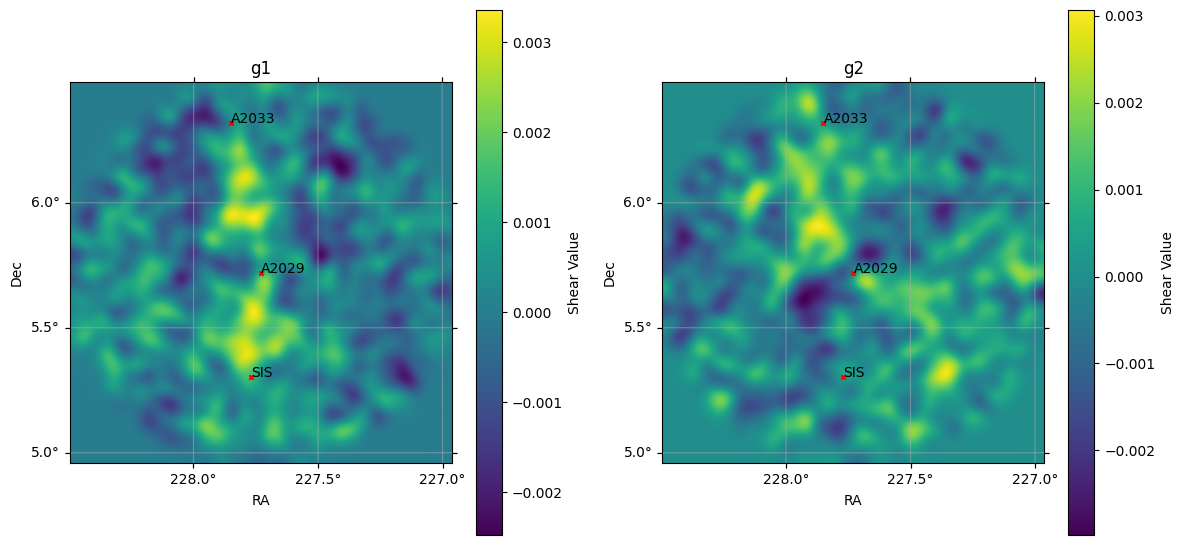

In [7]:
#Visualization g1 and g2

fig = plt.figure(figsize=(12, 6))

#--- g1 ---
ax1 = fig.add_subplot(1, 2, 1, projection=image_WCS)  
im1 = ax1.imshow(gaussian_filter(grid_g1.T, sigma=30), origin='lower', extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max])
fig.colorbar(im1, ax=ax1, label='Shear Value')
ax1.scatter(Cluster1.x, Cluster1.y, s=10, c='r', marker='x')
ax1.text(Cluster1.x + cell_size, Cluster1.y + cell_size, c = 'k', s=Cluster1.name, fontsize=10, alpha = 1)
ax1.scatter(Cluster2.x, Cluster2.y, s=10, c='r', marker='x')
ax1.text(Cluster2.x + cell_size, Cluster2.y + cell_size, c = 'k', s=Cluster2.name, fontsize=10, alpha = 1)
ax1.scatter(Cluster3.x, Cluster3.y, s=10, c='r', marker='x')
ax1.text(Cluster3.x + cell_size, Cluster3.y + cell_size, c = 'k', s=Cluster3.name, fontsize=10, alpha = 1)
ra = ax1.coords[0]
ra.set_axislabel('RA')
ra.set_major_formatter('d.d') 
dec = ax1.coords[1]
dec.set_axislabel('Dec')
dec.set_major_formatter('d.d')   
ax1.set_title('g1')
ax1.grid(True, alpha=0.5)

#--- g2 ---
ax2 = fig.add_subplot(1, 2, 2, projection=image_WCS) 
im2 = ax2.imshow(gaussian_filter(grid_g2.T, sigma=30), origin='lower', extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max])
fig.colorbar(im2, ax=ax2, label='Shear Value')
ax2.scatter(Cluster1.x, Cluster1.y, s=10, c='r', marker='x')
ax2.text(Cluster1.x + cell_size, Cluster1.y + cell_size, c = 'k', s=Cluster1.name, fontsize=10, alpha = 1)
ax2.scatter(Cluster2.x, Cluster2.y, s=10, c='r', marker='x')
ax2.text(Cluster2.x + cell_size, Cluster2.y + cell_size, c = 'k', s=Cluster2.name, fontsize=10, alpha = 1)
ax2.scatter(Cluster3.x, Cluster3.y, s=10, c='r', marker='x')
ax2.text(Cluster3.x + cell_size, Cluster3.y + cell_size, c = 'k', s=Cluster3.name, fontsize=10, alpha = 1)
ra = ax2.coords[0]
ra.set_axislabel('RA')
ra.set_major_formatter('d.d') 
dec = ax2.coords[1]
dec.set_axislabel('Dec')
dec.set_major_formatter('d.d')
ax2.set_title('g2')
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

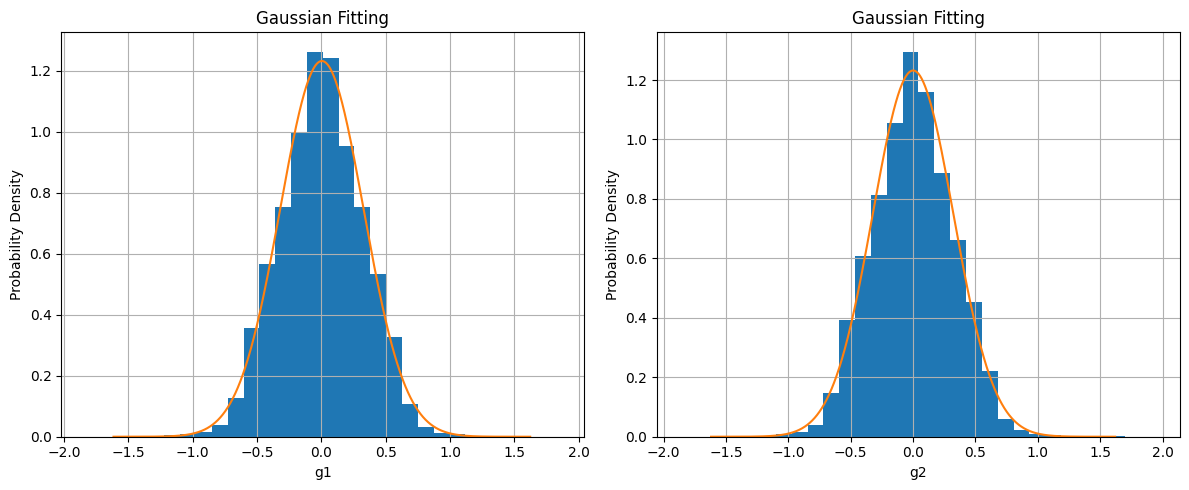

Mean g1 =  0.004228428343153538 ; Std Dev g1 =  0.32381906699057855
Mean g2 =  3.188008605827425e-05 ; Std Dev g2 =  0.3238148974513788


In [8]:
#g1, g2 distributions
#But be wary of only including the occupied cells

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
g1_mean, g1_std_dev = norm.fit(grid_g1[occupied])    
g1_delta = 5
g1 = np.linspace(g1_mean - g1_delta*g1_std_dev, g1_mean + g1_delta*g1_std_dev, 1000)
pdf_g1 = norm.pdf(g1, g1_mean, g1_std_dev)
#Plot the Gaussian distribution
plt.hist(grid_g1[occupied], bins = 30, density = True)
plt.plot(g1, pdf_g1)
plt.title('Gaussian Fitting')
plt.xlabel('g1')
plt.ylabel('Probability Density')
plt.grid(True)

plt.subplot(1, 2, 2)
g2_mean, g2_std_dev = norm.fit(grid_g2[occupied])    
g2_delta = 5
g2 = np.linspace(g2_mean - g2_delta*g2_std_dev, g2_mean + g2_delta*g2_std_dev, 1000)
pdf_g2 = norm.pdf(g2, g2_mean, g2_std_dev)
#Plot the Gaussian distribution
plt.hist(grid_g2[occupied], bins = 30, density = True)
plt.plot(g2, pdf_g2)
plt.title('Gaussian Fitting')
plt.xlabel('g2')
plt.ylabel('Probability Density')
plt.grid(True)

#Show both plots
plt.tight_layout()
plt.show()

print('Mean g1 = ', g1_mean, '; Std Dev g1 = ', g1_std_dev)
print('Mean g2 = ', g2_mean, '; Std Dev g2 = ', g2_std_dev)

In [9]:
#Assuming data is dominated by noise; Set sigma_noise for MCMC parameter estimation (at end of notebook)

sigma_noise = np.sqrt((g1_std_dev**2 + g2_std_dev**2)/2)
print('Std Dev of Noise per component = ',  sigma_noise)

Std Dev of Noise per component =  0.3238169822276897


In [10]:
#Intrinsic Ellipticity Distribution 

#Std Dev of g1 or g2 is different from the std dev of the complex ellipticity. 
#Instrinsic Source Ellipticity refers to sqrt(stdev(g1**2) + stdev(g2**2)) instead 

intrinsic_ellipticity_dispersion = np.sqrt(g1_std_dev**2 + g2_std_dev**2)
print('The intrinsic ellipticity dispersion = ', intrinsic_ellipticity_dispersion)

The intrinsic ellipticity dispersion =  0.4579463679931262


In [11]:
#Defining filter

class Filter:
    
    def __init__(self, ClusterA_class, ClusterB_class, phi, k0, hc, r1, r2):
        self.ClusterA = ClusterA_class
        self.ClusterB = ClusterB_class
        self.phi = phi
        self.k0 = k0 
        self.hc = hc
        self.r1 = r1 
        self.r2 = r2
    
    def fil_line_eqn(self, x, y):
        return (y - self.ClusterA.y) - math.tan(self.phi) * (x - self.ClusterA.x)
    
    def ortho_fil_line_eqn(self, x, y):
        if math.tan(self.phi) == 0:
            return x - self.ClusterA.x
        return (y - self.ClusterA.y) + (1/math.tan(self.phi)) * (x - self.ClusterA.x)
        
    def weight(self, x, y):

        #Ensure x and y are numpy arrays
        x = np.asarray(x)
        y = np.asarray(y)
        
        #Pre-compute constant values
        intercluster_distance = math.dist([self.ClusterA.x, self.ClusterA.y], 
                                          [self.ClusterB.x, self.ClusterB.y])

        r1_dist = self.r1 * intercluster_distance
        r2_dist = self.r2 * intercluster_distance
        
        #Distance from filament ray
        h = np.abs(self.fil_line_eqn(x, y) * math.cos(self.phi))
        
        #Distance from cluster center
        r = np.sqrt((x - self.ClusterA.x)**2 + (y - self.ClusterA.y)**2)
        
        #WCS conversion
        point_ra, point_dec = image_WCS.wcs_pix2world(x, y, 1)[0], image_WCS.wcs_pix2world(x, y, 1)[1]
        
        #Reference point calculation
        proj_point_x = (self.ClusterA.x + 
                       ((x - self.ClusterA.x) * math.cos(self.phi) + 
                        (y - self.ClusterA.y) * math.sin(self.phi)) * math.cos(self.phi))
        proj_point_y = (self.ClusterA.y + 
                       ((x - self.ClusterA.x) * math.cos(self.phi) + 
                        (y - self.ClusterA.y) * math.sin(self.phi)) * math.sin(self.phi))
        
        proj_point_ra, proj_point_dec = image_WCS.wcs_pix2world(proj_point_x, proj_point_y, 1)[0], image_WCS.wcs_pix2world(proj_point_x, proj_point_y, 1)[1]
        
        #Create SkyCoord objects
        point_SC = SkyCoord(point_ra*u.deg, point_dec*u.deg, frame='icrs')
        proj_point_SC = SkyCoord(proj_point_ra*u.deg, proj_point_dec*u.deg, frame='icrs')
        
        #Angular separation
        angular_separation = proj_point_SC.separation(point_SC)
        
        #Distance scaling
        distance_scaling = cosmo.angular_diameter_distance(z=self.ClusterA.redshift).value
        
        h_Mpc = np.abs(angular_separation.rad) * distance_scaling
        hc_Mpc = self.hc #* cell_Mpc
        
        #Weight calculation
        weights = np.zeros_like(x, dtype=float)
        
        #Condition for orthogonal line and distance checks
        ortho_condition = (self.ortho_fil_line_eqn(self.ClusterA.x + math.cos(self.phi), self.ClusterA.y + math.sin(self.phi)) * self.ortho_fil_line_eqn(x, y)) > 0
        
        distance_condition = (r > r1_dist) & (r < r2_dist)

        ortho_or_circle_condition = (ortho_condition) | (r < intercluster_distance)
        
        #Weight calculation conditions
        weight_conditions = ortho_condition & distance_condition
        
        #Compute weights based on conditions
        mask_within_hc = weight_conditions & (h_Mpc < hc_Mpc)
        mask_beyond_hc = weight_conditions & (h_Mpc > hc_Mpc)
        
        weights[mask_within_hc] = self.k0
        weights[mask_beyond_hc] = self.k0 / (1 + ((h_Mpc[mask_beyond_hc] - hc_Mpc) / hc_Mpc)**2)
        
        return weights, ortho_or_circle_condition

    #Adding a new function to limit MCMC parameter estimation to a binary window around detected filament direction
    def fixed_window(self, x, y, fixed_hc_Mpc = 1.5): #Consider this multiple of hc around filament peak to create window

        #Ensure x and y are numpy arrays
        x = np.asarray(x)
        y = np.asarray(y)
        
        #Pre-compute constant values
        intercluster_distance = math.dist([self.ClusterA.x, self.ClusterA.y], 
                                          [self.ClusterB.x, self.ClusterB.y])

        r1_dist = self.r1 * intercluster_distance
        r2_dist = self.r2 * intercluster_distance
        
        #Distance from filament ray
        h = np.abs(self.fil_line_eqn(x, y) * math.cos(self.phi))
        
        #Distance from cluster center
        r = np.sqrt((x - self.ClusterA.x)**2 + (y - self.ClusterA.y)**2)
        
        #WCS conversion
        point_ra, point_dec = image_WCS.wcs_pix2world(x, y, 1)[0], image_WCS.wcs_pix2world(x, y, 1)[1]
        
        #Reference point calculation
        proj_point_x = (self.ClusterA.x + 
                       ((x - self.ClusterA.x) * math.cos(self.phi) + 
                        (y - self.ClusterA.y) * math.sin(self.phi)) * math.cos(self.phi))
        proj_point_y = (self.ClusterA.y + 
                       ((x - self.ClusterA.x) * math.cos(self.phi) + 
                        (y - self.ClusterA.y) * math.sin(self.phi)) * math.sin(self.phi))
        
        proj_point_ra, proj_point_dec = image_WCS.wcs_pix2world(proj_point_x, proj_point_y, 1)[0], image_WCS.wcs_pix2world(proj_point_x, proj_point_y, 1)[1]
        
        #Create SkyCoord objects
        point_SC = SkyCoord(point_ra*u.deg, point_dec*u.deg, frame='icrs')
        proj_point_SC = SkyCoord(proj_point_ra*u.deg, proj_point_dec*u.deg, frame='icrs')
        
        #Angular separation
        angular_separation = proj_point_SC.separation(point_SC)
        
        #Distance scaling
        distance_scaling = cosmo.angular_diameter_distance(z=self.ClusterA.redshift).value
        
        h_Mpc = np.abs(angular_separation.rad) * distance_scaling
        hc_Mpc = self.hc #* cell_Mpc
        
        #Weight calculation
        weights = np.zeros_like(x, dtype=float)
        
        #Condition for orthogonal line and distance checks
        ortho_condition = (self.ortho_fil_line_eqn(self.ClusterA.x + math.cos(self.phi), self.ClusterA.y + math.sin(self.phi)) * self.ortho_fil_line_eqn(x, y)) > 0
        
        distance_condition = (r > r1_dist) & (r < r2_dist)

        #ortho_or_circle_condition = (ortho_condition) | (r < 0.65*intercluster_distance)
        ortho_or_circle_condition = (ortho_condition) | (r < intercluster_distance)

        #Weight calculation conditions
        weight_conditions = ortho_condition & distance_condition
        
        #Compute weights based on conditions
        mask_within_n_hc = weight_conditions & (h_Mpc < fixed_hc_Mpc)
        mask_beyond_n_hc = weight_conditions & (h_Mpc > fixed_hc_Mpc)
        
        weights[mask_within_n_hc] = 1

        return weights.astype(bool)

In [12]:
#Defining filament

class Filament:
    
    def __init__(self, ClusterA_class, ClusterB_class, phi, k0, hc): #Cluster B not really required
        self.ClusterA = ClusterA_class
        self.ClusterB = ClusterB_class
        self.phi = phi
        self.k0 = k0 
        self.hc = hc #In units of Mpc
    
    def fil_line_eqn(self, x, y):
        return (y - self.ClusterA.y) - math.tan(self.phi) * (x - self.ClusterA.x)
    
    def ortho_fil_line_eqn(self, x, y):
        if math.tan(self.phi) == 0:
            return x - self.ClusterA.x
        return (y - self.ClusterA.y) + (1/math.tan(self.phi)) * (x - self.ClusterA.x)

    def shear_profile(self, x, y):

        #Ensure x and y are numpy arrays
        x = np.asarray(x)
        y = np.asarray(y)
        
        #Distance from filament ray
        h = np.abs(self.fil_line_eqn(x, y) * math.cos(self.phi))
        
        #Distance from cluster center
        r = np.sqrt((x - self.ClusterA.x)**2 + (y - self.ClusterA.y)**2)
        
        #WCS conversion
        point_ra, point_dec = image_WCS.wcs_pix2world(x, y, 1)[0], image_WCS.wcs_pix2world(x, y, 1)[1]
        
        #Reference point calculation
        proj_point_x = (self.ClusterA.x + 
                       ((x - self.ClusterA.x) * math.cos(self.phi) + 
                        (y - self.ClusterA.y) * math.sin(self.phi)) * math.cos(self.phi))
        proj_point_y = (self.ClusterA.y + 
                       ((x - self.ClusterA.x) * math.cos(self.phi) + 
                        (y - self.ClusterA.y) * math.sin(self.phi)) * math.sin(self.phi))
        
        proj_point_ra, proj_point_dec = image_WCS.wcs_pix2world(proj_point_x, proj_point_y, 1)[0], image_WCS.wcs_pix2world(proj_point_x, proj_point_y, 1)[1]
        
        #Create SkyCoord objects
        point_SC = SkyCoord(point_ra*u.deg, point_dec*u.deg, frame='icrs')
        proj_point_SC = SkyCoord(proj_point_ra*u.deg, proj_point_dec*u.deg, frame='icrs')
        
        #Angular separation
        angular_separation = proj_point_SC.separation(point_SC)
        
        #Distance scaling
        distance_scaling = cosmo.angular_diameter_distance(z=self.ClusterA.redshift).value
        
        h_Mpc = np.abs(angular_separation.rad) * distance_scaling
        hc_Mpc = self.hc 
        
        #Profile calculation
        k = np.zeros_like(x, dtype=float)
        
        #Condition for orthogonal line
        ortho_condition = (self.ortho_fil_line_eqn(self.ClusterA.x + math.cos(self.phi), self.ClusterA.y + math.sin(self.phi)) * self.ortho_fil_line_eqn(x, y)) > 0
        
        #Compute profile based on conditions
        mask_within_hc = ortho_condition & (h_Mpc < hc_Mpc)
        mask_beyond_hc = ortho_condition & (h_Mpc > hc_Mpc)
        
        k[mask_within_hc] = self.k0
        k[mask_beyond_hc] = self.k0 / (1 + ((h_Mpc[mask_beyond_hc] - hc_Mpc) / hc_Mpc)**2)
        
        return k

/tmp/ipykernel_2606998/3237946080.py:18: RuntimeWarning: overflow encountered in exp
  P_k_Shot = lambda k : P0*np.exp(k**2/(gal_density*math.log(2)))


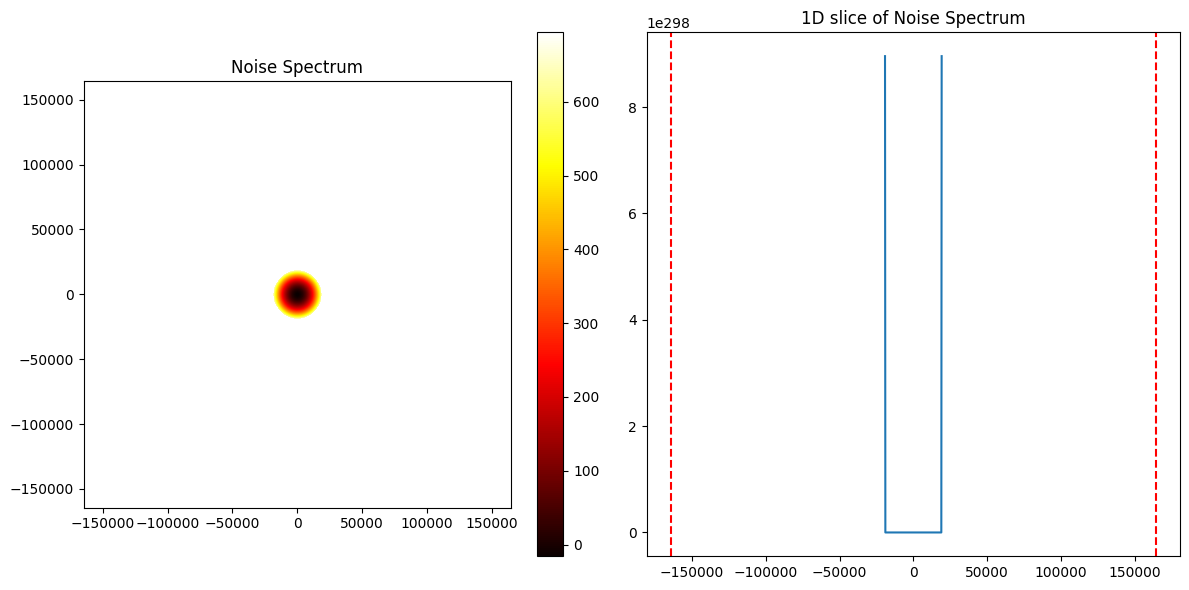

/tmp/ipykernel_2606998/3237946080.py:106: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(filter_function).T, cmap='hot', extent=[k.min(), k.max(), l.min(), l.max()], origin = 'lower')


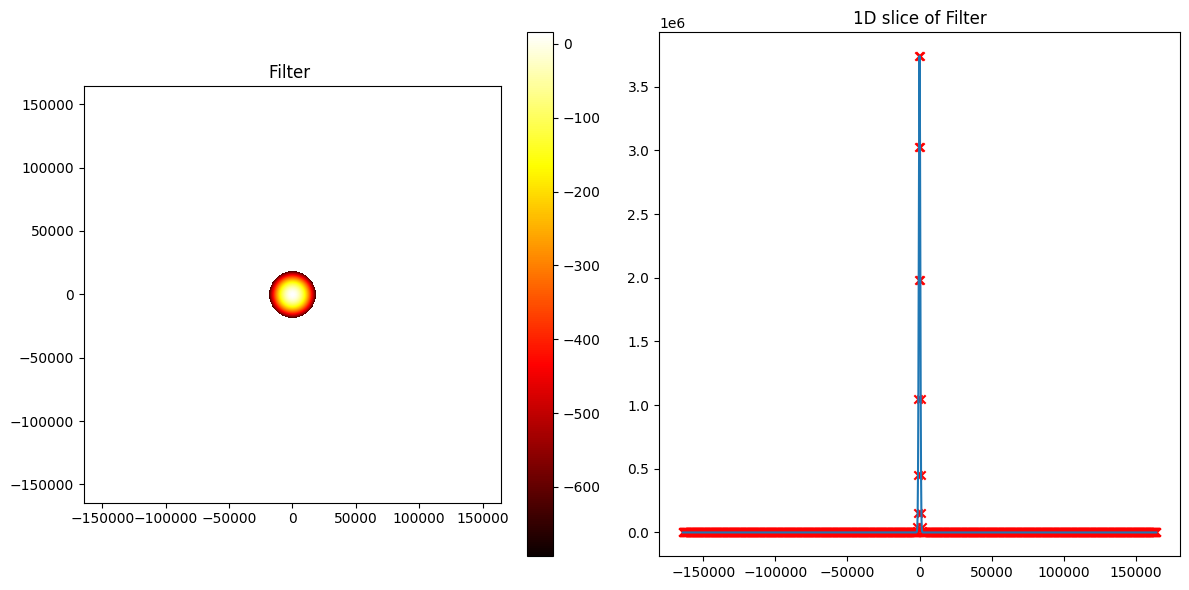

In [13]:
#Noise Power Spectrum and Optimal Filter
Lx_rad = grid_angular_length_x*(math.pi/180) #In rad
Ly_rad = grid_angular_length_y*(math.pi/180) #In rad

Nx_grid, Ny_grid = grid_size[0], grid_size[1] 
dx_rad, dy_rad = Lx_rad/Nx_grid, Ly_rad/Ny_grid #In rad

#Visualizing noise spectrum
sigma_e = 0.45 #Doesn't make any difference to the analysis
#Here we use effective gal_density_arcmin2 derived from the k_cut value 
#The optimal value of k_cut = 0.21 arcmin^-1 corresponds to a gal_density_arcmin2 = 0.064
gal_density_arcmin2 = 0.064
#Convert to rad^2 units
gal_density = gal_density_arcmin2*(((180/math.pi)*60)**2) #per rad^2
P0 = sigma_e**2/(2*gal_density)

#Shot noise spectrum 
P_k_Shot = lambda k : P0*np.exp(k**2/(gal_density*math.log(2)))

#Frequency range 
kmin = 2*math.pi/Lx_rad
kmax = math.pi/dx_rad

lmin = 2*math.pi/Ly_rad
lmax = math.pi/dy_rad

#Create frequency grid (K, L)
k = np.linspace(-kmax, kmax, Nx_grid) #Frequency range in x-direction
l = np.linspace(-lmax, lmax, Ny_grid) #Frequency range in y-direction

K, L = np.meshgrid(k, l, indexing='ij')

#Calculate radial frequency (distance from the center in frequency space)
R = np.sqrt(K**2 + L**2)

noise_spectrum = P_k_Shot(R) 

#Plot the matrix    
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(np.log(noise_spectrum).T, cmap='hot', extent=[k.min(), k.max(), l.min(), l.max()], origin = 'lower')
plt.colorbar()
plt.title('Noise Spectrum')

#1D slice of noise spectrum
plt.subplot(1, 2, 2)
plt.plot(k, noise_spectrum[:, int(len(k)/2)])
plt.axvline(x = k.min(), linestyle = '--', c = 'r')
plt.axvline(x = k.max(), linestyle = '--', c = 'r')
plt.title('1D slice of Noise Spectrum')

#Show both plots
plt.tight_layout()
plt.show()

#Function for optimizing filter
def noise_adjustment(weights):
    
    #Shot noise spectrum 
    P_k_Shot = lambda k : P0*np.exp(k**2/(gal_density*math.log(2)))

    #Frequency range 
    kmin = 2*math.pi/Lx_rad
    kmax = math.pi/dx_rad
    
    lmin = 2*math.pi/Ly_rad
    lmax = math.pi/dy_rad
    
    #Create frequency grid (K, L)
    k = np.linspace(-kmax, kmax, Nx_grid) #Frequency range in x-direction
    l = np.linspace(-lmax, lmax, Ny_grid) #Frequency range in y-direction
    
    K, L = np.meshgrid(k, l, indexing='ij')
    
    #Calculate radial frequency (distance from the center in frequency space)
    R = np.sqrt(K**2 + L**2)
    
    noise_spectrum = P_k_Shot(R)

    noise_spectrum_reciprocal = 1/noise_spectrum

    weights_fft = np.fft.fft2(weights)*(np.sqrt(dx_rad*dy_rad)/np.sqrt(Nx_grid*Ny_grid))  #2D FFT
    weights_fft_shifted = np.fft.fftshift(weights_fft)  #Shift zero frequency to the center
    
    #Filter adjustment
    #adjusted_filter = np.divide(weights_fft_shifted, 1*noise_spectrum.astype(np.complex128))
    adjusted_filter = np.multiply(weights_fft_shifted, noise_spectrum_reciprocal.astype(np.complex128))

    #Constructing the matched filter in real space 
    #Reverse the shift using np.fft.ifftshift
    adjusted_filter_unshifted = np.fft.ifftshift(adjusted_filter)
    
    #Apply the inverse 2D Fourier transform
    adjusted_filter_ifft = np.fft.ifft2(adjusted_filter_unshifted)
    
    optimal_matched_filter = np.real(adjusted_filter_ifft)

    return optimal_matched_filter

#Plotting filter function
filter_function = 1/noise_spectrum 

#Plot the matrix
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(np.log(filter_function).T, cmap='hot', extent=[k.min(), k.max(), l.min(), l.max()], origin = 'lower')
plt.colorbar()
plt.title('Filter ')

#1D slice of filter
plt.subplot(1, 2, 2)
plt.plot(k, filter_function[:, int(len(k)/2)])
plt.scatter(k, filter_function[:, int(len(k)/2)], marker = 'x', c = 'r')
plt.title('1D slice of Filter')

#Show both plots
plt.tight_layout()
plt.show()

In [14]:
#Main filament detection analysis
#Here we use sparse arrays (ie ignore empty cells that do not contribute to final calculation) to save time and compute

#Input parameters for filter
k0 = 1
hc =0.15 #Unit: Mpc
r1, r2 = 0.31, 0.62
ortho_cut = True #Do you want the filter to stop at the halfline
ref_angle = 0

#Sample angles
theta_array = np.linspace(0, 2*math.pi, 360+1) #Shifted theta axis (0, 360)

#Define empty signal, variance and std dev arrays
signal_T_array = np.zeros(len(theta_array))
signal_X_array = np.zeros(len(theta_array))

variance_T_array = np.zeros(len(theta_array))
variance_X_array = np.zeros(len(theta_array))

stdev_T_array = np.zeros(len(theta_array))
stdev_X_array= np.zeros(len(theta_array))

#For parameter estimation 
grid_gT_sparse_array = np.zeros((len(theta_array), np.sum(occupied))) 
grid_gX_sparse_array = np.zeros((len(theta_array), np.sum(occupied))) 

#Pre-extract static sparse values
grid_g1_sparse = grid_g1[occupied]
grid_g2_sparse = grid_g2[occupied]
grid_xc_sparse = grid_xc[occupied]
grid_yc_sparse = grid_yc[occupied]

#Pre-load ravel arrays
grid_xc_ravel = grid_xc.ravel()
grid_yc_ravel = grid_yc.ravel()

#Shear mag
grid_g_sparse = np.sqrt(grid_g1_sparse**2 + grid_g2_sparse**2)

#=========Pre-calculate adjusted filter integral using reference angle=================
Integral_Filter = Filter(Cluster1, Cluster2, ref_angle, k0, hc, r1, r2) 
IF_weights, IF_ortho_condition = Integral_Filter.weight(grid_xc_ravel, grid_yc_ravel)

IF_weights = IF_weights.reshape(grid_size)
IF_ortho_condition = IF_ortho_condition.reshape(grid_size) if ortho_cut else np.ones(grid_size)

#Noise adjustment to filter, multiply by ortho condition to avoid FFT shift rewrapping 
IF_adjusted_filter = IF_ortho_condition * noise_adjustment(IF_weights)

#For normalization (Can't use sum of each filter because it can get clipped) 
adjusted_filter_integral = np.sum(IF_adjusted_filter)
#================================================

#================== Main loop ==================
for t in range(len(theta_array)):
    
    theta = theta_array[t]
    cos2theta = math.cos(2*theta)
    sin2theta = math.sin(2*theta)

    #Rotate g1, g2 -> gT, gX using sparse entries only
    grid_gT_sparse = - grid_g1_sparse * cos2theta - grid_g2_sparse * sin2theta
    grid_gX_sparse =   grid_g1_sparse * sin2theta - grid_g2_sparse * cos2theta
    
    #Useful for parameter estimation later
    grid_gT_sparse_array[t] = grid_gT_sparse
    grid_gX_sparse_array[t] = grid_gX_sparse
    
    #Define Filter 
    Matched_Filter = Filter(Cluster1, Cluster2, theta, k0, hc, r1, r2) 

    weights, ortho_condition = Matched_Filter.weight(grid_xc_ravel, grid_yc_ravel)
    weights = weights.reshape(grid_size)
    ortho_condition = ortho_condition.reshape(grid_size) if ortho_cut else np.ones(grid_size)
    
    #Noise adjustment to filter, multiply by ortho condition to avoid FFT shift rewrapping 
    #Adjust filter in full 2D shape
    adjusted_filter_sparse = ortho_condition[occupied] * noise_adjustment(weights)[occupied]

    #Extract sparse entries for fast signal calculation
    norm_adjusted_filter_sparse = adjusted_filter_sparse / adjusted_filter_integral

    #Calculate signal 
    weighted_gT = grid_gT_sparse * norm_adjusted_filter_sparse
    weighted_gX = grid_gX_sparse * norm_adjusted_filter_sparse
    
    signal_T_array[t] = np.sum(weighted_gT)
    signal_X_array[t] = np.sum(weighted_gX)

    #S-Statistics (From Schirmer Thesis) (Def1)
    variance_T_array[t] = np.sum((norm_adjusted_filter_sparse ** 2) * (grid_g_sparse ** 2)) / 2
    variance_X_array[t] = np.sum((norm_adjusted_filter_sparse ** 2) * (grid_g_sparse ** 2)) / 2

    stdev_T_array[t] = np.sqrt(variance_T_array[t])
    stdev_X_array[t] = np.sqrt(variance_X_array[t])

/tmp/ipykernel_2606998/3237946080.py:60: RuntimeWarning: overflow encountered in exp
  P_k_Shot = lambda k : P0*np.exp(k**2/(gal_density*math.log(2)))


In [15]:
#Define color palette for plots 

palette = {
    "T": 'blue', 
    "X": 'red',
    "theta1": 'darkviolet', #'darkviolet'
    "theta2": 'deeppink', #orangered
    'intercluster_direction': 'darkgreen',
    'cluster_center': 'yellow', 
    'cluster_members':'green'
}

palette_keys = list(palette.keys())   

Filament Candidate at 108.0 degrees ; Significance = 6.37
Filament Candidate at 261.0 degrees ; Significance = 7.26


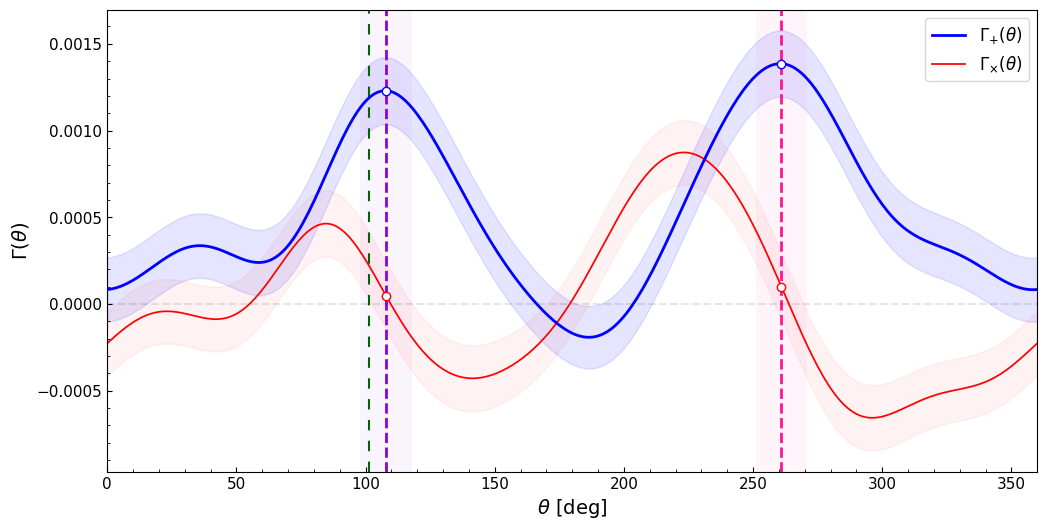

In [16]:
#Plot1 (Linear Signal)

#Locate local minima 
signal_T_maxima_index = argrelextrema(signal_T_array, np.greater)[0]
signal_T_maxima_theta = theta_array[signal_T_maxima_index]

# #Include specific elements and redefine 'signal_T_maxima_theta'
select = [1,2]
signal_T_maxima_index = signal_T_maxima_index[select]
signal_T_maxima_theta = signal_T_maxima_theta[select]

signal_T_maxima  = signal_T_array[signal_T_maxima_index]
signal_X_maxima  = signal_X_array[signal_T_maxima_index]
significance = signal_T_maxima/stdev_T_array[signal_T_maxima_index]

plt.figure(figsize=(12, 6))

#Tangential signal
plt.plot(np.degrees(theta_array), signal_T_array, c = palette["T"], label =  r'$\Gamma_{+}(\theta)$', alpha = 1, linewidth = 2, zorder = 100)
plt.fill_between(np.degrees(theta_array), signal_T_array + stdev_T_array, signal_T_array - stdev_T_array, color=palette["T"], alpha=0.1) #, label='1 $\sigma$ Uncertainty')

#Cross signal 
plt.plot(np.degrees(theta_array), signal_X_array, c = palette["X"],  label = r'$\Gamma_{\times}(\theta)$', alpha = 1, linewidth = 1.25) 
plt.fill_between(np.degrees(theta_array), signal_X_array + stdev_X_array, signal_X_array - stdev_X_array, color=palette["X"], alpha=0.05)#, label='1 $\sigma$ Uncertainty')

#Go over each peak 
for i in range(len(signal_T_maxima_theta)):
    # #To avoid repeated legends
    # if i == 0: 
    #     plt.axvline(np.degrees(signal_T_maxima_theta[i]), c = 'b', linestyle='--', linewidth=1.2), label = 'Detection')
    # else: 
    #     plt.axvline(np.degrees(signal_T_maxima_theta[i]), c = 'b', linestyle='--', linewidth=1.2)
    plt.axvline(np.degrees(signal_T_maxima_theta[i]), c = palette[palette_keys[i+2]], linestyle='--', linewidth=2, alpha =1)
    plt.scatter(np.degrees(signal_T_maxima_theta[i]), signal_T_maxima[i], edgecolors=palette['T'], marker = 'o', facecolors='white', alpha = 1, zorder = 200)
    plt.scatter(np.degrees(signal_T_maxima_theta[i]), signal_X_maxima[i], edgecolors=palette['X'], marker = 'o', facecolors='white', alpha = 1, zorder = 200)
    print('Filament Candidate at ' + str(round(np.degrees(signal_T_maxima_theta[i]), 2)) + ' degrees', '; Significance = ' + str(round(significance[i], 2)))

#plt.axvline(x = np.degrees(intercluster_angle), c = 'g', linestyle='--', linewidth=1, label = 'Intercluster Direction')
plt.axvline(x = 0 + np.degrees(intercluster_angle), c = palette['intercluster_direction'], linestyle=(0, (5, 5)), linewidth=1.5)#, label = 'Intercluster Direction')
plt.axvline(x = 360 + np.degrees(intercluster_angle_2), c = palette['intercluster_direction'], linestyle=(0, (5, 5)), linewidth=1.5)#, label = 'Intercluster Direction')

#Create opacity windows around detections 
vspan_window = 10
vspan_low = np.degrees(signal_T_maxima_theta)  - vspan_window
vspan_high = np.degrees(signal_T_maxima_theta) + vspan_window
vspan_alpha = 0.045
vspan_facecolor = [palette['theta1'] ,  palette['theta2']]
for i in range(len(signal_T_maxima_theta)):
    plt.axvspan(vspan_low[i], vspan_high[i], alpha = vspan_alpha, facecolor= vspan_facecolor[i], linestyle = '--')

#Other
plt.axhline(y = 0, c = 'k', linestyle = '--', alpha = 0.1)
plt.xlim(np.degrees(theta_array).min(),np.degrees(theta_array).max())
#plt.title('Tangential Signal vs Angle')
plt.xlabel(r'$\theta$ [deg]', fontsize=14)
plt.ylabel(r'$\Gamma(\theta)$', fontsize=14)
plt.grid(True, alpha = 0)
plt.legend(fontsize=12)

#Add minor ticks
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(direction='in', which = 'both')   #ticks point inward
ax.tick_params(axis='both', labelsize=11)      #increase tick label font size
plt.show()

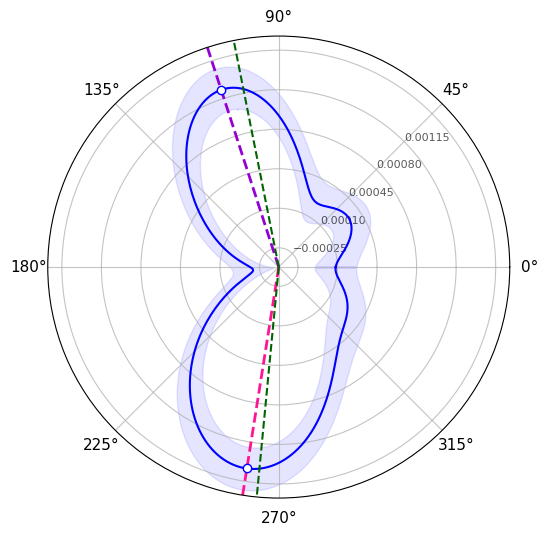

In [17]:
#Plot2 (Polar Signal)

fig = plt.figure(figsize=(6, 6))
ax2 = fig.add_subplot(1, 1, 1, projection = 'polar')  #use WCS here

#Plot signal
ax2.plot(theta_array, signal_T_array, label= r'$\Gamma_{+}(\theta)$', c = palette['T'])
#Fill the area between the signal and the standard deviation lines
ax2.fill_between(theta_array, signal_T_array - stdev_T_array, signal_T_array + stdev_T_array, color=palette['T'], alpha=0.1)

#Set radial limits for
range_expand = 0.025  #Ratio by which range should be expanded
signal_T_range = max(signal_T_array + stdev_T_array) - min(signal_T_array - stdev_T_array)
signal_X_range = max(signal_X_array) - min(signal_X_array)
signal_T_rmin, signal_T_rmax = min(signal_T_array - stdev_T_array) - range_expand * signal_T_range, max(signal_T_array + stdev_T_array) + range_expand * signal_T_range
# signal_X_rmin, signal_X_rmax = min(signal_X_array) - range_expand * signal_X_range, max(signal_X_array) + range_expand * signal_X_range
# rmin = min(signal_T_rmin, signal_X_rmin)
# rmax = max(signal_T_rmax, signal_X_rmax)
rmin = signal_T_rmin
rmax = signal_T_rmax
ax2.set_ylim(rmin, rmax)

#Keep only n radial ticks between rmin and rmax
r_tick_start = -0.00025      #starting value
r_tick_increment = 0.00035    #increment
num_ticks = 6     # number of increments
r_ticks = r_tick_start + r_tick_increment * np.arange(num_ticks)
ax2.set_yticks(r_ticks)

#Customize tick labels and opacity 
ax2.tick_params(axis='x', labelsize=11)
ax2.tick_params(axis='y', labelsize=8)
for label in ax2.get_yticklabels():
    label.set_alpha(0.65)
for label in ax2.get_xticklabels():
    label.set_alpha(1)
    
#Remove the highest tick
r_ticks = ax2.get_yticks()
r_ticklabels = ax2.get_yticklabels()
# angle_ticks = ax2.get_xticks()
# angle_ticklabels = ax2.get_xticklabels()
    
#Hide the last rticklabel
for label in r_ticklabels[-1:]:
    label.set_visible(False)
# ax2.set_yticks(r_ticks[:-1]) #Just remove the last tick completely 

#Plot peaks in plot
for i in range(len(signal_T_maxima_theta)):
    peak_angle = signal_T_maxima_theta[i]
    ax2.plot([peak_angle, peak_angle], [rmin, rmax], c=palette[palette_keys[i+2]], linestyle='--', linewidth=2)
    ax2.scatter(peak_angle, signal_T_maxima[i], edgecolors=palette['T'], marker = 'o', facecolors='white', alpha = 1, zorder = 200)

#Intracluster direction
ax2.plot([intercluster_angle, intercluster_angle], [rmin, rmax], c=palette['intercluster_direction'], linestyle='--', linewidth=1.5, label='Intercluster Direction')
ax2.plot([intercluster_angle_2, intercluster_angle_2], [rmin, rmax], c=palette['intercluster_direction'], linestyle='--', linewidth=1.5, label='Intercluster Direction')

# ax2.set_title(r'Tangential Signal [$\Gamma_+(\theta)$]')
ax2.set_rlabel_position(45)
# ax2.legend(loc = 'upper right', borderaxespad = 0)
ax2.grid(alpha=0.75)  #applies to all gridlines
plt.show()

In [18]:
#Create an dictionary indexed by w to store MCMC data at all angles 
sample_list = {}

Running MCMC...
 k0 = 0.040 ± 0.010
 hc = 0.255 ± 0.066
Acceptance fraction: 0.712


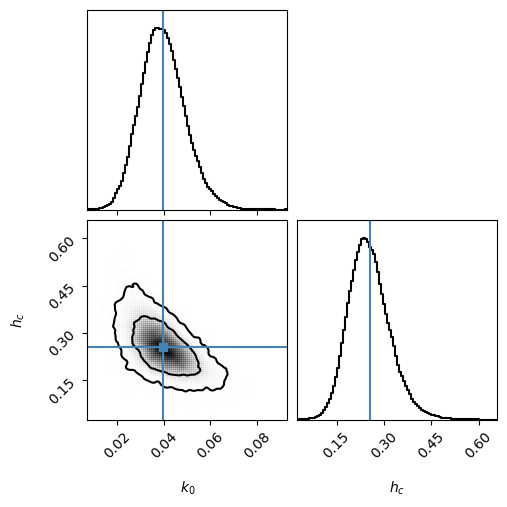

In [19]:
#MCMC Sampling to get uncertainties [Optimized]

#=====Pre-compute k,h-independent data for faster computation=====
#Specify Peak Angle Index 
w = 0
peak_angle = signal_T_maxima_theta[w]
peak_angle_index = signal_T_maxima_index[w] 

#Data
grid_gT_sparse = grid_gT_sparse_array[peak_angle_index]

#Define residual function
def compute_normalized_residual(k, h, w):

    #Define Filter and Filament 
    Matched_Filter = Filter(Cluster1, Cluster2, peak_angle, k, h, r1, r2) 
    fixed_window_sparse = Matched_Filter.fixed_window(grid_xc_sparse, grid_yc_sparse)

    Template_Fil = Filament(Cluster1, Cluster2, peak_angle, k, h)
    temp_gT_sparse = Template_Fil.shear_profile(grid_xc_sparse, grid_yc_sparse)

    residual = np.sum((grid_gT_sparse[fixed_window_sparse] - temp_gT_sparse[fixed_window_sparse])**2)

    gaussian_noise_sigma = (g1_std_dev + g2_std_dev)/2
    prefactor = (0.5/gaussian_noise_sigma**2)
    constant = 0.5*(fixed_window_sparse.sum())*math.log(2 * math.pi * gaussian_noise_sigma**2)
    
    normalized_residual = prefactor*residual + constant

    return normalized_residual 

#Define the likelihood function 
def log_likelihood(params):
    k, h = params
    normalized_residual = compute_normalized_residual(k, h, w)
    return -normalized_residual  

#Define the prior function
def log_prior(params):
    k, h = params
    if k1 < k < k2 and h1 < h < h2:
        return 0  #Log-prior is 0 (uniform distribution)
    else:
        return -np.inf  #If parameters are out of bounds, return zero prior

#Define the log probability function (prior + likelihood)
def log_posterior(params):
    lp = log_prior(params)
    if np.isfinite(lp):
        return lp + log_likelihood(params)
    else:
        return -np.inf

#Parallelize the MCMC process using multiprocessing
def run_mcmc_parallel(initial_pos, nsteps, nwalkers):
    
    with multiprocessing.Pool() as pool:
        #Initialize the MCMC sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)

        #Run MCMC in parallel
        print("Running MCMC...")
        sampler.run_mcmc(initial_pos, nsteps)

        return sampler

#Set up MCMC parameters
ndim = 2  
nwalkers = 50 
nsteps = 2000 
burn_in = 200 

k1, k2 = 0.001, 0.1
h1, h2 = 0.01, 0.75

initial_pos = np.column_stack([
    np.random.uniform(k1, k2, nwalkers), 
    np.random.uniform(h1, h2, nwalkers)  
])

#Run MCMC
sampler = run_mcmc_parallel(initial_pos, nsteps, nwalkers)

#Get the chain of parameter values
samples = sampler.get_chain(flat=True, discard=burn_in)

#Store in list for corner plots
sample_list[w] = samples

#Find the best (k, h) that minimizes the error
#Calculate the mean and 1-sigma bounds for the minima estimate
k0, hc = np.mean(samples, axis=0) 
sigma_k0, sigma_hc = np.std(samples, axis=0)  #1-sigma uncertainty

print(f" k0 = {k0:.3f} ± {sigma_k0:.3f}")
print(f" hc = {hc:.3f} ± {sigma_hc:.3f}")

#Plot the corner plot
fig = corner.corner(samples, labels=["$k_0$", "$h_c$"], smooth = 1, smooth1d = 1, levels = [0.68, 0.95], plot_contours = True, fill_contours = False, plot_datapoints = False, truths=[k0, hc], bins = 100)

acceptance_fraction = np.mean(sampler.acceptance_fraction)
print(f"Acceptance fraction: {acceptance_fraction:.3f}")

#print('Autocorrelation Time (in steps)= ', sampler.get_autocorr_time())

Running MCMC...
 k0 = 0.036 ± 0.007
 hc = 0.444 ± 0.082
Acceptance fraction: 0.709


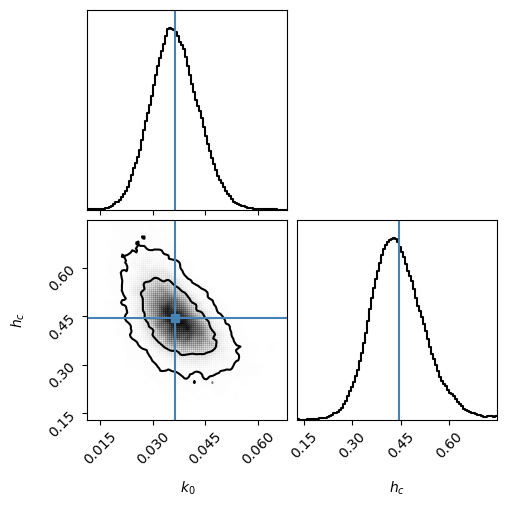

In [20]:
#MCMC Sampling to get uncertainties [Optimized]

#===== Pre-compute k,h-independent data for faster computation=====
#Specify Peak Angle Index 
w = 1
peak_angle = signal_T_maxima_theta[w]
peak_angle_index = signal_T_maxima_index[w] 

#Data
grid_gT_sparse = grid_gT_sparse_array[peak_angle_index]

#Define residual function
def compute_normalized_residual(k, h, w):

    #Define Filter and Filament 
    Matched_Filter = Filter(Cluster1, Cluster2, peak_angle, k, h, r1, r2) 
    fixed_window_sparse = Matched_Filter.fixed_window(grid_xc_sparse, grid_yc_sparse)

    Template_Fil = Filament(Cluster1, Cluster2, peak_angle, k, h)
    temp_gT_sparse = Template_Fil.shear_profile(grid_xc_sparse, grid_yc_sparse)

    residual = np.sum((grid_gT_sparse[fixed_window_sparse] - temp_gT_sparse[fixed_window_sparse])**2)

    gaussian_noise_sigma = (g1_std_dev + g2_std_dev)/2
    prefactor = (0.5/gaussian_noise_sigma**2)
    constant = 0.5*(fixed_window_sparse.sum())*math.log(2 * math.pi * gaussian_noise_sigma**2)
    
    normalized_residual = prefactor*residual + constant

    return normalized_residual 

#Define the likelihood function
def log_likelihood(params):
    k, h = params
    normalized_residual = compute_normalized_residual(k, h, w)
    return -normalized_residual 

#Define the prior function
def log_prior(params):
    k, h = params
    if k1 < k < k2 and h1 < h < h2:
        return 0  #Log prior is 0 (uniform distribution)
    else:
        return -np.inf  #If parameters are out of bounds, return zero prior

#Define the log probability function (prior + likelihood)
def log_posterior(params):
    lp = log_prior(params)
    if np.isfinite(lp):
        return lp + log_likelihood(params)
    else:
        return -np.inf

#Parallelize the MCMC process using multiprocessing
def run_mcmc_parallel(initial_pos, nsteps, nwalkers):
    
    with multiprocessing.Pool() as pool:
        #Initialize the MCMC sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)

        #Run MCMC in parallel
        print("Running MCMC...")
        sampler.run_mcmc(initial_pos, nsteps)

        return sampler

#Set up MCMC parameters
ndim = 2  
nwalkers = 50 
nsteps = 2000 
burn_in = 200 

k1, k2 = 0.001, 0.1
h1, h2 = 0.01, 0.75

initial_pos = np.column_stack([
    np.random.uniform(k1, k2, nwalkers),  
    np.random.uniform(h1, h2, nwalkers)   
])

#Run MCMC 
sampler = run_mcmc_parallel(initial_pos, nsteps, nwalkers)

#Get the chain of parameter values
samples = sampler.get_chain(flat=True, discard=burn_in)

#Store in list for corner plots
sample_list[w] = samples

#Find the best (k, h) that minimizes the error
#Calculate the mean and 1-sigma bounds for the minima estimate
k0, hc = np.mean(samples, axis=0) 
sigma_k0, sigma_hc = np.std(samples, axis=0)  #1-sigma uncertainty

print(f" k0 = {k0:.3f} ± {sigma_k0:.3f}")
print(f" hc = {hc:.3f} ± {sigma_hc:.3f}")

#Plot the corner plot
fig = corner.corner(samples, labels=["$k_0$", "$h_c$"], smooth = 1, smooth1d = 1, levels = [0.68, 0.95], plot_contours = True, fill_contours = False, plot_datapoints = False, truths=[k0, hc], bins = 100)

acceptance_fraction = np.mean(sampler.acceptance_fraction)
print(f"Acceptance fraction: {acceptance_fraction:.3f}")

#print('Autocorrelation Time (in steps)= ', sampler.get_autocorr_time())

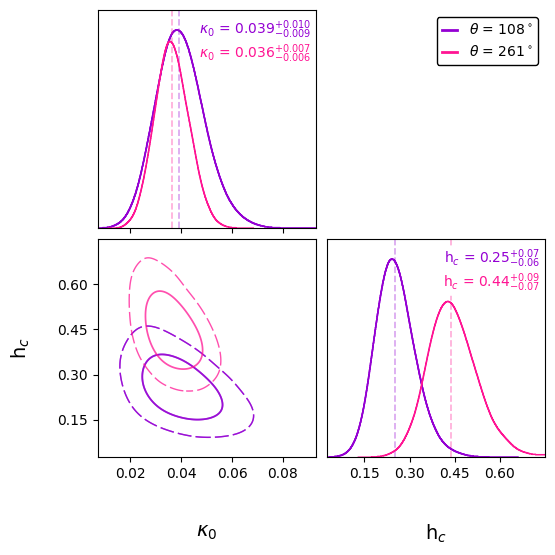

In [21]:
#Combined corner plot 

#Choose which sample indices you want to plot together
select_w = [0, 1]
colors = [palette['theta1'], palette['theta2']]

labels = [r"$\kappa_0$", r"h$_c$"]

#Make a bigger figure first
fig = plt.figure(figsize=(6, 6)) 

#Create figure 
figure = corner.corner(
    sample_list[select_w[0]],
    labels=labels,
    smooth=40,
    smooth1d=20,
    levels=[0.68, 0.95],
    plot_datapoints=False,
    plot_density=False,
    plot_contours=True,
    fill_contours=False,
    contour_kwargs={"colors": colors[0], "linewidths": [1, 1.25], "linestyles": [(5,(10, 3)), '-'],  "alpha": 0.75},
    hist_kwargs={"color": colors[0], "linewidth": 1.1},
    bins=750,
    show_titles=False,
    title_kwargs={"fontsize": 13},
    label_kwargs={"fontsize": 14, "labelpad": 0},
    fig = fig 
)

#Overlay all (repeats the first one)
for idx, color, new_idx in zip(select_w, colors, np.arange(len(select_w))):
    
    corner.corner(
        sample_list[idx],
        labels=labels,
        smooth=40,
        smooth1d=20,
        levels=[0.68, 0.95],
        plot_datapoints=False,
        plot_density=False,
        plot_contours=True,
        fill_contours=False,
        contour_kwargs={"colors": color, "linewidths": [1, 1.25], "linestyles": [(5,(10, 3)), '-'], "alpha": 0.75},
        hist_kwargs={"color": color, "linewidth": 1.1},
        bins=750,
        show_titles=False,
        title_kwargs={"fontsize": 13},
        label_kwargs={"fontsize": 14, "labelpad": 0},
        fig=figure,   
    )

    #Compute median and percentiles
    medians = np.percentile(sample_list[idx], [16, 50, 84], axis=0)

    axes = np.array(figure.axes).reshape((len(labels), len(labels)))
    for i in range(len(labels)):
        ax = axes[i, i]

        #Dashed line at the median
        ax.axvline(medians[1, i], color=color, ls="--", lw=1.25, alpha=0.35)

        #Format string like in your example plot
        lo = medians[1, i] - medians[0, i]
        hi = medians[2, i] - medians[1, i]

        #Kappa result text
        if i == 0:
            txt = (rf"{labels[i]} = {medians[1,i]:.3f}" + r"$^{+" + f"{hi:.3f}" + r"}_{-" + f"{lo:.3f}" + r"}$")
            #Add text annotation to top-right of diagonal plots
            ax.text(0.98, 0.96 - 0.11*new_idx,  #vertical shift for multiple overlays
                txt,
                color=color,
                ha="right", va="top", transform=ax.transAxes,
                fontsize=10,
                alpha = 1, 
                bbox=dict(facecolor="white", edgecolor="none", alpha=1, boxstyle="round,pad=0.1"))

        #Hc result text
        if i == 1:
            txt = (rf"{labels[i]} = {medians[1,i]:.2f}" + r"$^{+" + f"{hi:.2f}" + r"}_{-" + f"{lo:.2f}" + r"}$")
            #Add text annotation to top-right of diagonal plots
            ax.text(0.98, 0.96 - 0.11*new_idx,  #vertical shift for multiple overlays
                txt,
                color=color,
                ha="right", va="top", transform=ax.transAxes,
                fontsize=10,
                alpha = 1, 
                bbox=dict(facecolor="white", edgecolor="none", alpha=1, boxstyle="round,pad=0.1"))

#Fix tick label rotation
for ax in figure.get_axes():
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="y", labelrotation=0)

from matplotlib.lines import Line2D

#Create custom handles for legend
legend_elements = [
    Line2D([0], [0], color=c, lw=2, label=rf"$\theta$ = {np.round(np.degrees(signal_T_maxima_theta[w])).astype(int)}$^\circ$")
    for w, c in zip(select_w, colors)
]

#Get axes grid 
axes = np.array(figure.axes).reshape((len(labels), len(labels)))

#Pick the top-right diagonal subplot
ax_legend = axes[0, 1]

#Add legend there
ax_legend.legend(
    handles=legend_elements,
    loc="upper right",
    fontsize=10,
    frameon=True,
    fancybox=True,
    framealpha=1,
    edgecolor="black", 
    handlelength=1.1,   
    handletextpad=0.8   
)

plt.show()